In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
Nmics = 8
Nsamp = 50
# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)
# Spacing between microphones
pitch = 0.1
# proxy for sampling rate
dist_per_samp = 0.1
# Speed of sound in the medium
C = 0.5
# Time dilation factor for sinc pulse: how narrow
SincP = 5.0
# CODE Locations of microphones
# I have used divide by 1/pitch instead of multiple by pitch to get rid of rounding errors
mics = []
# Location of point obstacle
obstacle = (3, -1)

Above , constant have been defined , and below the standard functions used 

In [3]:
def wsrc(t):
    return np.sinc(SincP*t)

def sqd(a,b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5

def dist(src, pt, mic):
    d1 = sqd(src,pt)
    d2 = sqd(pt,mic)
    return d1 + d2

def get_mics(Nmics,pitch):
    return  [(0,(i - (Nmics+1)/2 + ((Nmics+1)%2)//2 )/(1/pitch)) for i in range(Nmics,0,-1)]

def invert(A):
        B = []
        for i in range(len(A[0])):
            B.append([0]*len(A))
        for i in range(len(A)):
            for j in range(len(A[i])):
                B[j][i] = A[i][j]
        return B

def source_wave(wsrc,dist_per_samp,Nsamp,C,offset):
    x = np.arange(offset,Nsamp*dist_per_samp+offset,dist_per_samp)
    s =[]
    for i in range(Nsamp):
        s.append(wsrc((dist_per_samp*i-offset)/C))
    #print(x,s)
    plt.plot(x,s)
    plt.show()

The above function 'source_wave' allows us to generate and analyse the source wave with different parameters and at different time instants

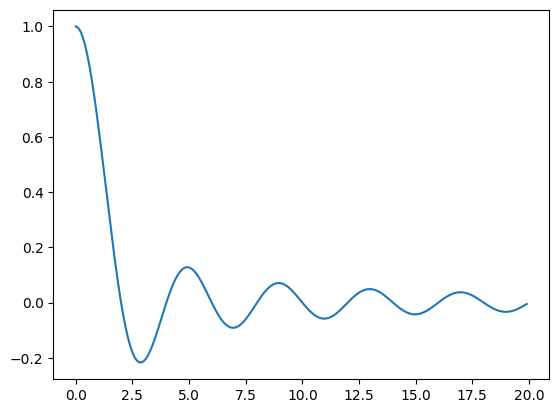

In [4]:
#Sinc Pulse 1
source_wave(wsrc,dist_per_samp,200,10,0)

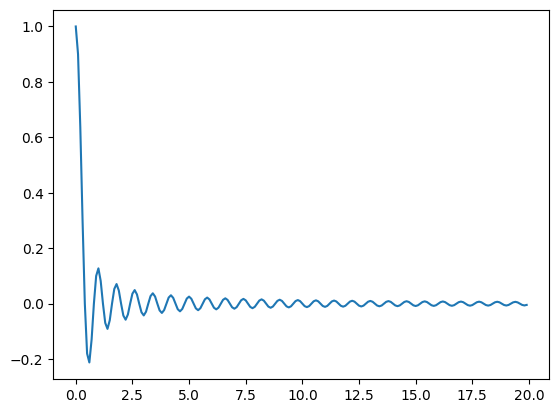

In [5]:
# Sinc Pulse 2
source_wave(wsrc,dist_per_samp,200,2,0)

# Question 1
How to generate such a pulse:
Use the wsrc function to generate the value of the source value at t = 0 . increase t by a small value and repeat. Then plot these values on the y axis with time as the x axis.

How to make the 2 different pulses:
We change the parameter C , which is a constant for a given wave . It determines how closesly spaced the peaks and minimas are . Higher value of C means closer peaks, this is because the time input to wsrc is multiplied by a factor of 1/C
Therefore , to achieve the 2 different pulses , C must be changed to 10 and 2 respectively for the given 2 pulses.

Effect on final image:
Sharper and closer peaks intuitively seem like they will give sharper images. Closer peaks implies a smaller wavelength which means the accuracy of the result is likely to be higher. 


In [6]:
def generate(obstacle , Nmics , Nsamp , src , pitch , dist_per_samp , C , SincP ):
    D = {}
    mics = get_mics(Nmics,pitch)
    for i in range(Nmics):
        D[i] = []
        offset = dist(src,obstacle,mics[i])
        #print(mics[i],offset)
        #print(offset,src,obstacle,mics[i])
        for j in range(Nsamp):
            x = (j*dist_per_samp-offset)/C
            # The below if else case handling is to ensure that the source emitted no sound waves for t < 0 
            # To remove this feature , set symmetric to True
            symmetric = True
            if(x < 0 and not symmetric ):
                D[i].append(0)
            else:
                D[i].append(wsrc(x))
        
    return D,mics

In [7]:
Nsamp = 200
C = 2.0
Nmics = 64
obstacle = (3,-1)
D,mics = generate(obstacle , Nmics , Nsamp , src , pitch , dist_per_samp , C , SincP )
p = False
if(p == True):
    for i in D:
        print(D[i])

# Question 2
Does it make sense to reconstruct up to Nsamp ?
Answer is No. The maximum distance that a sound wave can travel in the given amount of time is
Nsamp * dist_per_samp . For one of the microphones to pick the reflected sound wave up , the ditance from source to object to microphone should be less than this. Int he above cases wherein src is at (0,0) , the maximum distance of an object that can be detected is at a distance of Nsamp * dist_per_samp/(2 * x) . Where x is the distance between 2 consecutive points on the x-axis , witch in this case is 0.1 units (or the pitch).

In [8]:
def DAS(D,mics,Nsamp,Nmics,dist_per_samp,pitch,obstacle,src):
    Grid = []
    # defining xlen and ylen keeping in mind that the obstacle is in the range
    #x_len , y_len = max(Nmics,int(abs(obstacle[0])/pitch +1)), max(int(Nsamp//2),int(obstacle[0]/pitch +1))
    x_len , y_len = Nmics , int(Nsamp//2)
    for i in range(y_len):
        t = [0]*x_len
        Grid.append(t)
    #x axis width = pitch
    #y axis width = dist_per_samp

    for k in range(len(mics)):
        for i in range(len(Grid)):
            for j in range(-len(Grid[i])//2,len(Grid[i])//2):
                try:
                    (x,y) = ((i+1)*pitch,j*pitch)
                    offset = int((dist(src,(x,y),mics[k]))/dist_per_samp)
                    #if(i == 29):
                        #print(i,j,x,y,obstacle,(x-obstacle[0])**2 + (y-obstacle[1])**2)
                    if(((x-obstacle[0])**2 + (y-obstacle[1])**2 )== 0):
                        #print('a',k,D[k][offset],D[k].index(max(D[k])),offset,max(D[k]))
                        pass
                    Grid[i][j+Nmics//2] += D[k][offset]

                except:
                    pass
    return Grid
Grid = DAS(D,mics,Nsamp,Nmics,dist_per_samp,pitch,obstacle,src)

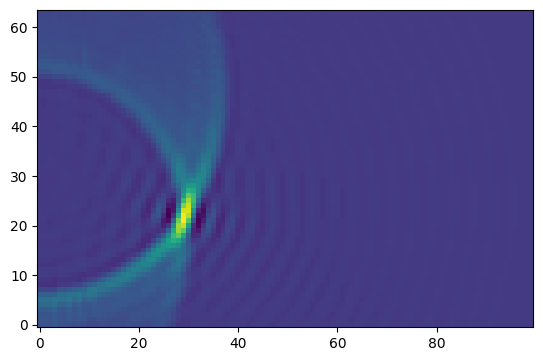

In [9]:
ctr = 0
def visualise(Grid):
    global ctr
    x = invert(Grid)
    fig, ax = plt.subplots()
    ax.imshow(x,origin = 'lower')
    plt.savefig('A8_'+str(ctr))
    ctr += 1
visualise(Grid)

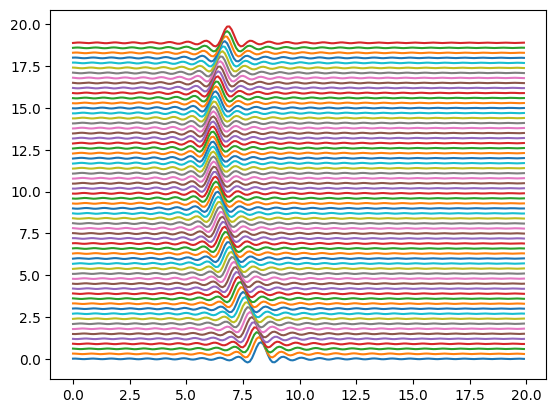

In [10]:
# Visualisation of the sound waves receieved by the microphones. 
Z = {}
for i in D:
    Z[i] = D[i][:]
x = np.arange(0,Nsamp*dist_per_samp,dist_per_samp)
p = True
if(p == True):
    
    fig, ax = plt.subplots()
    t = 0.3
    c = 0
    for i in Z:
        for j in range(len(Z[i])):
            Z[i][j] += c*t
        c += 1
        plt.plot(x,Z[i])
    plt.show()

# Question 3
The (x,y) coordinates of the maximum amplitude is at (30,22) because the each point on the grid has been scaled and actually represents a unti square of pitch * pitch units square. Here pitch is 0.1 , therefore , (30,22) is actually (3,2.2) units in the real world coordinates. Also the x-axis is shifted by Nmics/2 * pitch units , which in this case is 3.2 units. This shift of the x-axis means every y value from the grid is actually 3.2 units more than what it should be. Accoutning fro this , our result becomes (3,-1) which is the exact location of the obstacle.

# Question 4
General solution for maximum obstacle x and y can be calculated using the following formula :
Nsamp * dist_per_samp > min(dist(src,(x,y),mics[i]))
The solution to this inequality is a conic section. 
For the given case , LHS of the equation is 20 units. This gives the limits to be (10,0) on the x-axis and (0,+-8.4) for the y-limit.

# Question 5
Intuitive explanation for why smaller C gives sharper image is that the peak of the curve with smaller C is much more sharply defined . This means that during reconstruction of image ,  the neighbouring points , will have a very small amplitude because the sharpness of the curve ensures that the higher contributions go only to the target location.


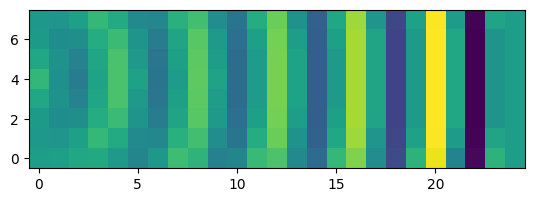

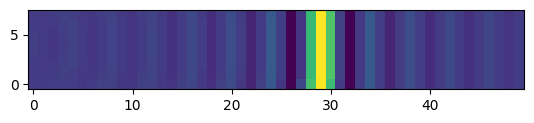

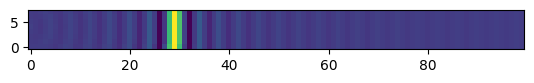

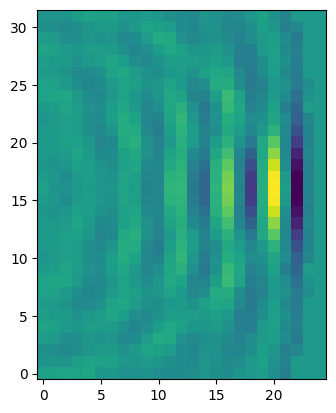

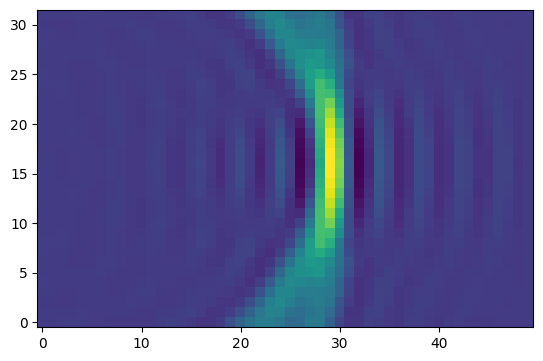

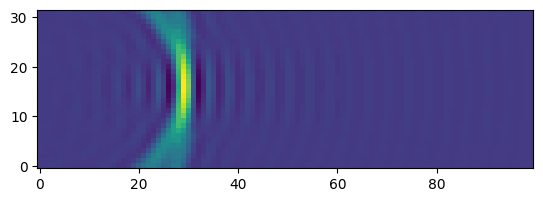

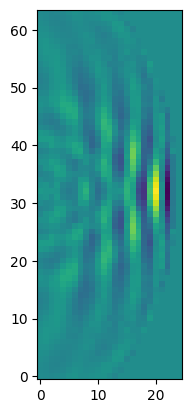

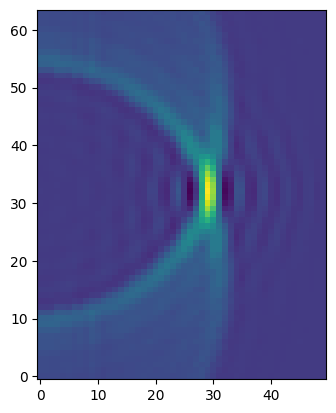

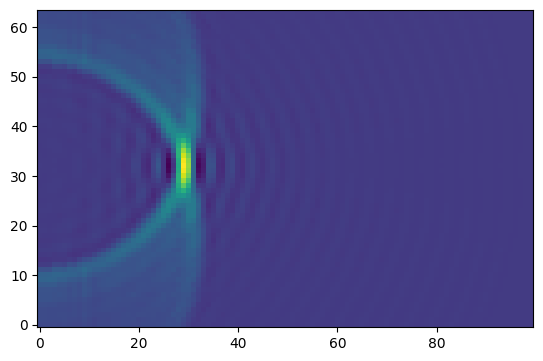

In [11]:
obstacle = (3,0)
for i in [8,32,64]:
    for j in [50,100,200]:
        Nmics = i
        Nsamp = j
        D,mics = generate(obstacle , Nmics , Nsamp , src , pitch , dist_per_samp , C , SincP )
        Grid = DAS(D,mics,Nsamp,Nmics,dist_per_samp,pitch,obstacle,src)
        visualise(Grid)

# Question 6
As we increase the Number of Samples , the localisation of the x- coordinate of the obstacle improves greatly.
As we increase the Number of mics, the localisation 
    of the y-coordinate of the obstacle improves greatly.

From this information , depending on our use case requirements , we can choose to increase Number of Samples or Number of Mics , depending on which accuracy is more important to us , x or y axis accuracy.

In [12]:
def get_data(f):
    f = open(f,'r')
    D = {}
    mics = get_mics(Nmics,pitch)
    c = 0
    for i in f.readlines():
        D[c] = list(float(x) for x in i.split())
        c += 1
    return D,mics

In [13]:
# A filter which removes noise and allows us to easily identify the centre of the bright spots
# It also prints out the coordinates of the objects of highest intensity
def simple_filter(img): 
    res = np.empty([len(img),len(img[0])],dtype = float)
    for i in range(len(img)):
        for j in range(len(img[i])):
            su = 0
            shift = 1
            c = 1
            for k in range(3):
                for l in range(3):
                    try:
                        x = img[i+k-shift][j+l-shift]
                        if(x > img[i][j]):
                            c += 1
                    except:
                        x = 0
            res[i][j] = img[i][j]/(c**2)
            if(c == 1 and res[i][j] > 50):
                print(i,j)
    return res
            
    

19 32
29 42


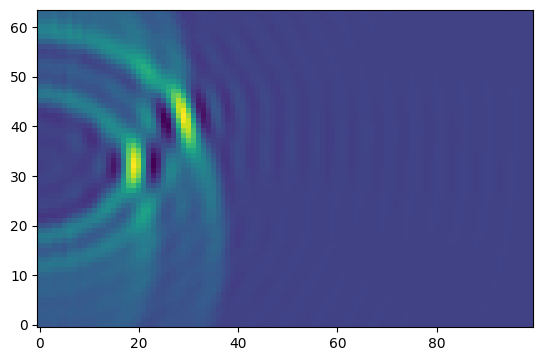

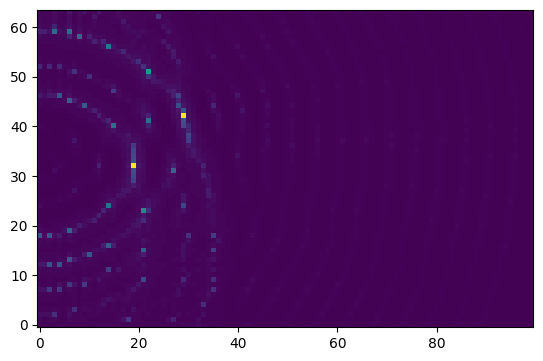

In [14]:
# Problem 1
Nmics = 64
Nsamp = 200
pitch = 0.1
dist_per_samp = 0.1
C = 0.5
D, mics = get_data('rx2.txt')
Grid = DAS(D,mics,Nsamp,Nmics,dist_per_samp,pitch,obstacle,src)
visualise(Grid)
Grid = simple_filter(Grid)
visualise(Grid)

19 32
29 42
39 27


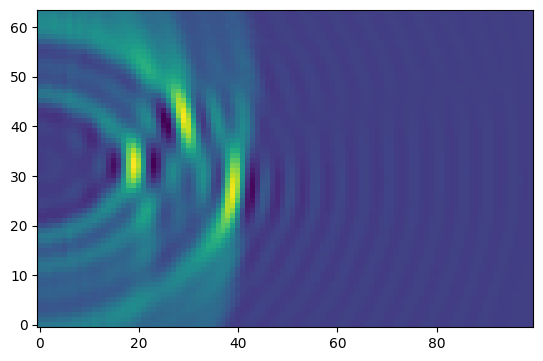

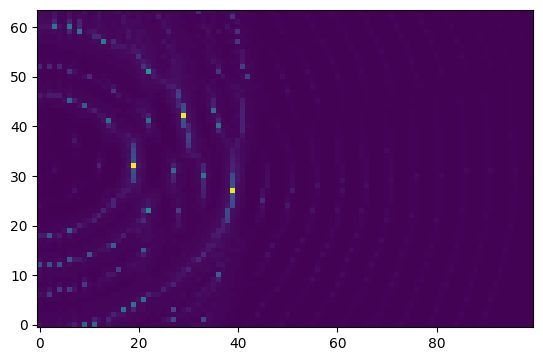

In [15]:
# Problem 2
Nmics = 64
Nsamp = 200
pitch = 0.1
dist_per_samp = 0.1
C = 0.5
D, mics = get_data('rx3.txt')
Grid = DAS(D,mics,Nsamp,Nmics,dist_per_samp,pitch,obstacle,src)
visualise(Grid)
Grid = simple_filter(Grid)
visualise(Grid)

# Inferences and Observations
For rx2.txt , we see 2 bright spots indicating 2 objects at the following locations:
(1.9,0)
,(2.9, 1)

Similarly for rx3.txt we see 3 bright spots indicating 3 objects at the following locations :
(1.9,0)
,(2.9, 1)
,(3.9,-0.5)
        

Inference from this is that distinct objects , if placed sufficiently faer apart can be detected simultaneously by DAS algorithm.